# Applying Classification Modeling
The goal of this week's assessment is to find the model which best predicts whether a person will default on their loan. In doing so, we want to utilize all of the different tools we have learned over the course: data cleaning, EDA, feature engineering/transformation, feature selection, hyperparameter tuning, and model evaluation. 

Dataset: The dataset comes customers default payments in Taiwan. More information about the dataset and columns are found in the link below.

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#


You will fit three different models (KNN, Logistic Regression, and Decision Tree Classifier) and use gridsearch to find the best hyperparameters for those models. Then you will compare the performance of those three models on a test set to find the best one.  


## Process/Expectations

#### You will be working in pairs for this assessment; please have ONE notebook and be prepared to explain how you worked in your pair.
1. Clean up your data set so that you can do EDA. This includes handling null values, categorical variables, removing unimportant columns, and removing outliers.
2. Perform EDA to identify opportunities to create new features.
    - [Great Example of EDA for classification](https://www.kaggle.com/stephaniestallworth/titanic-eda-classification-end-to-end) 
    - [Using Pairplots with Classification](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166)
3. Create polynomial and/or interaction features. You must also create at least 2 new features that are not interactions or polynomial transformations. For example, you can create a new dummy variable that based on the value of a continuous variable (billamount6 >2000) or take the average of some past amounts.
4. Perform some feature selction. This can happen beforehand using F-scores, or you can do it as part of your model building process by looking at the weights of your regularized logistic regression or feature importance of your decision tree.  
5. You must fit each of the three models to your data and tune at least 1 hyperparameter per model. 
6. After identifying the best hyperparameters for each model, fit those models to the test set and identify the best model overall using the evaluation metric of your choice.
7. Present your best model.

In [33]:
# import libraries
import pandas as pd
from math import exp
from scipy.stats import norm
from scipy import stats
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import warnings
import statsmodels.api as sm

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils import resample

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score

## 1. Data Cleaning

In [2]:
df = pd.read_csv('student_data.csv')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,2873,350000,1,1,2,37,-2,-2,-2,-2,...,466,466,316,316,316,466,466,316,316,0
1,3598,50000,2,2,1,37,2,2,2,0,...,13026,13268,13497,5500,0,580,600,600,600,0
2,27623,50000,2,1,2,23,-1,-1,-1,-1,...,4800,9810,660,2548,2321,4800,9810,660,2980,0
3,6874,20000,1,3,1,56,0,0,0,0,...,13784,13420,13686,1508,1216,1116,0,490,658,0
4,6444,110000,2,2,2,32,0,0,0,0,...,108829,110557,106082,5400,5400,4100,4100,4100,4200,0


In [4]:
df.drop(columns = ['ID'], inplace = True)
df.rename(columns = {'default payment next month':'DEFAULT'}, inplace = True) 

## 2. EDA

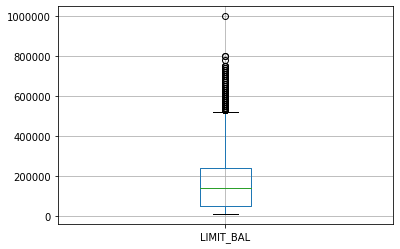

In [6]:
df.boxplot('LIMIT_BAL')

In [7]:
df.loc[df['LIMIT_BAL']>900000]
df.drop(index=[13774], inplace=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24]), <a list of 24 Text xticklabel objects>)

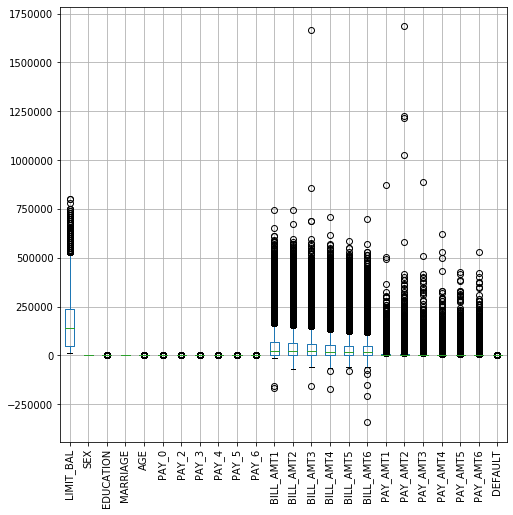

In [8]:
pd.DataFrame.boxplot(df,figsize=(8,8))
plt.xticks(rotation=90)

## 3. Feature Engineering

In [9]:
education_dummies = pd.get_dummies(df['EDUCATION'], prefix='education')
marriage_dummies = pd.get_dummies(df['MARRIAGE'], prefix='marriage')
df = pd.concat([df, education_dummies, marriage_dummies], axis=1)
df.drop(columns = ['EDUCATION','MARRIAGE'], inplace = True)
df.columns

In [10]:
df.drop(columns = ['EDUCATION','MARRIAGE'], inplace = True)
df.columns

Index(['LIMIT_BAL', 'SEX', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'DEFAULT', 'education_0',
       'education_1', 'education_2', 'education_3', 'education_4',
       'education_5', 'education_6', 'marriage_0', 'marriage_1', 'marriage_2',
       'marriage_3'],
      dtype='object')

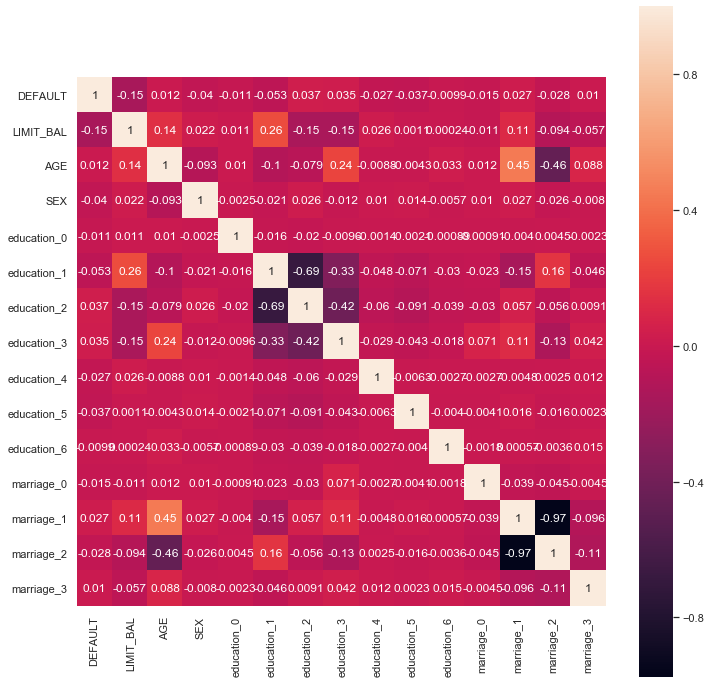

In [11]:
corrmat = df[['DEFAULT','LIMIT_BAL', 'AGE','SEX', 'education_0', 'education_1', 'education_2',
       'education_3', 'education_4', 'education_5', 'education_6',
       'marriage_0', 'marriage_1', 'marriage_2', 'marriage_3']].corr()

sns.set(font_scale=1)
fig,ax= plt.subplots()
fig.set_size_inches(10,10)
plt.tight_layout()
sns.heatmap(corrmat,square=True,annot=True, cbar = True)

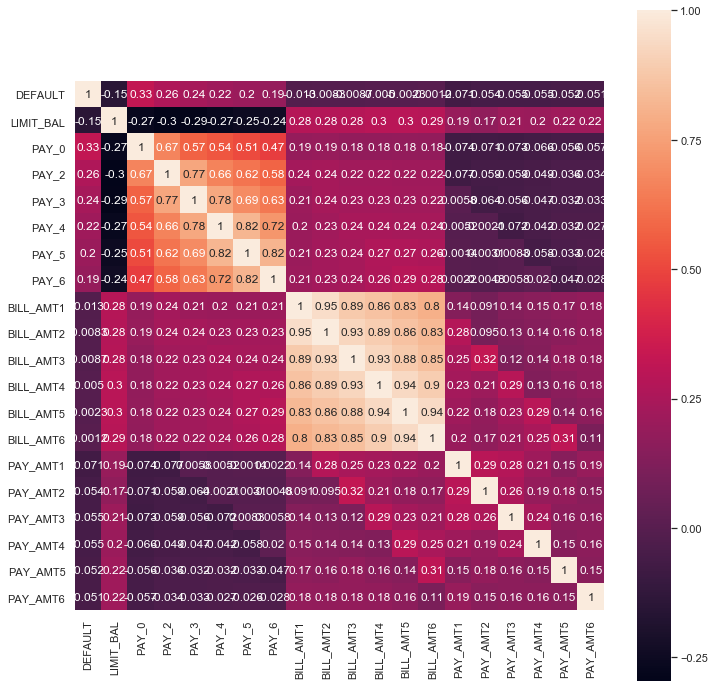

In [12]:
corrmat = df[['DEFAULT','LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',\
              'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', \
              'BILL_AMT6', 'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',\
              'PAY_AMT6']].corr()
sns.set(font_scale=1)
fig,ax= plt.subplots()
fig.set_size_inches(10,10)
plt.tight_layout()
sns.heatmap(corrmat,square=True,annot=True, cbar = True)

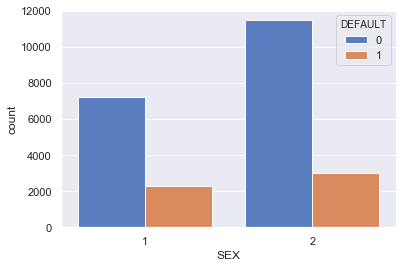

In [13]:
sns.countplot(x="SEX", data=df,hue="DEFAULT", palette="muted")

In [14]:
# df.PAY_0 = np.where(df.PAY_0 < 1 , 0, df.PAY_0)
# df.PAY_0 = np.where(df.PAY_0 >=1 , 1, df.PAY_0)

# df.PAY_2 = np.where(df.PAY_2 < 1 , 0, df.PAY_0)
# df.PAY_2 = np.where(df.PAY_2 >=1 , 1, df.PAY_0)

# df.PAY_3 = np.where(df.PAY_3 < 1 , 0, df.PAY_0)
# df.PAY_3 = np.where(df.PAY_3 >=1 , 1, df.PAY_0)

# df.PAY_4 = np.where(df.PAY_4 < 1 , 0, df.PAY_0)
# df.PAY_4 = np.where(df.PAY_4 >=1 , 1, df.PAY_0)

# df.PAY_5 = np.where(df.PAY_5 < 1 , 0, df.PAY_0)
# df.PAY_5 = np.where(df.PAY_5 >=1 , 1, df.PAY_0)

# df.PAY_6 = np.where(df.PAY_6 < 1 , 0, df.PAY_0)
# df.PAY_6 = np.where(df.PAY_6 >=1 , 1, df.PAY_0)

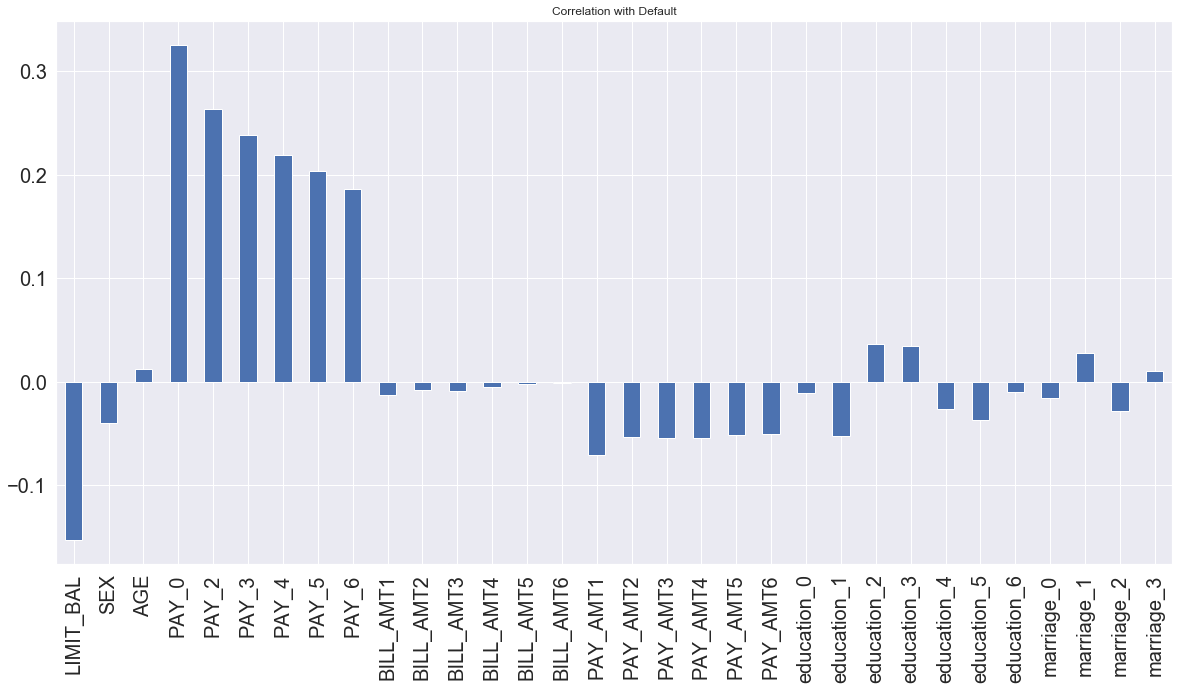

In [15]:
X = df.drop(['DEFAULT'],axis=1)
y = df['DEFAULT']

X.corrwith(df['DEFAULT']).plot.bar(
        figsize = (20, 10), title = "Correlation with Default", fontsize = 20,
        rot = 90, grid = True)

## 4. Feature Selection

In [16]:
# recursive feature selection

In [17]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'DEFAULT', 'education_0',
       'education_1', 'education_2', 'education_3', 'education_4',
       'education_5', 'education_6', 'marriage_0', 'marriage_1', 'marriage_2',
       'marriage_3'],
      dtype='object')

In [18]:
features=df[['LIMIT_BAL', 'SEX', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'education_0',
       'education_1', 'education_2', 'education_3', 'education_4',
       'education_5', 'education_6', 'marriage_0', 'marriage_1', 'marriage_2',
       'marriage_3']]

In [19]:
# min_train = X_train.min()
# range_train = (X_train - min_train).max()
# X_train_scaled = (X_train - min_train)/range_train

In [20]:
# min_test = X_test.min()
# range_test = (X_test - min_test).max()
# X_test_scaled = (X_test - min_test)/range_test

## 5. Model Fitting and Hyperparameter Tuning
KNN, Logistic Regression, Decision Tree

In [21]:
X = df.drop('DEFAULT', axis = 1)
y = df['DEFAULT']
feature_cols = X.columns

In [22]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Logistic Regression

In [23]:
# Create intercept term
X = sm.add_constant(X)

# Fit model
logit_model = sm.Logit(y, X)

# Get results of the fit
result = logit_model.fit()

         Current function value: 0.464375
         Iterations: 35


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [24]:
logreg = LogisticRegression(fit_intercept = False, C = 1e15, solver='liblinear')
model_log = logreg.fit(X, y)
model_log

LogisticRegression(C=1000000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

### KNN

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [26]:
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

In [27]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
print(knn)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')


In [28]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [29]:
# make class predictions for the testing set
y_pred_class = knn.predict(X_test)

In [30]:
# calculate accuracy
print('Accuracy:' + str(metrics.accuracy_score(y_test, y_pred_class)))
print('F1:' + str(metrics.f1_score(y_test, y_pred_class)))

Accuracy:0.7316666666666667
F1:0.37402799377916013


## Final Model: XGBoost

In [31]:
df['DEFAULT'].value_counts()

0    18690
1     5308
Name: DEFAULT, dtype: int64

In [39]:
X = df.drop('DEFAULT', axis = 1)
y = df['DEFAULT']
feature_cols = X.columns

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)

In [41]:
training = pd.concat([X_train,y_train], axis =1)

In [45]:
ndefault = training[training['DEFAULT']==0]
default = training[training['DEFAULT']==1]

In [48]:
upsampled = resample(default,
                          replace=True, # sample with replacement
                          n_samples=len(ndefault), # match number in majority class
                          random_state=23) # reproducible results

upsampled = pd.concat([ndefault, upsampled])
upsampled['DEFAULT'].value_counts()

1    14032
0    14032
Name: DEFAULT, dtype: int64

In [49]:
upsampled

,LIMIT_BAL,SEX,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,education_2,education_3,education_4,education_5,education_6,marriage_0,marriage_1,marriage_2,marriage_3,DEFAULT
18610,380000,2,33,1,1,2,2,2,2,363944,...,1,0,0,0,0,0,1,0,0,0
15020,250000,2,29,0,0,0,0,0,0,180056,...,1,0,0,0,0,0,1,0,0,0
15875,120000,2,37,-2,-2,-2,-2,-2,-1,874,...,1,0,0,0,0,0,0,1,0,0
13456,490000,1,41,1,2,0,0,0,0,230090,...,0,0,0,0,0,0,1,0,0,0
1891,320000,2,47,-1,-1,2,-1,2,-1,10159,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20292,60000,1,36,-1,2,2,-1,-1,-2,780,...,0,0,0,0,0,0,0,1,0,1
21411,50000,2,31,0,0,0,2,0,0,45074,...,1,0,0,0,0,0,1,0,0,1
20147,20000,1,48,-1,0,-1,-1,2,0,1522,...,0,1,0,0,0,0,1,0,0,1
19840,330000,2,27,0,0,0,0,2,2,322464,...,0,0,0,0,0,0,0,1,0,1


In [59]:
# ndefault = df[df['DEFAULT']==0]
# default = df[df['DEFAULT']==1]

# upsampled = resample(default,
#                           replace=True, # sample with replacement
#                           n_samples=len(ndefault), # match number in majority class
#                           random_state=23) # reproducible results

# upsampled = pd.concat([ndefault, upsampled])
# upsampled['DEFAULT'].value_counts()

In [55]:
X_train = upsampled.drop('DEFAULT', axis = 1)
y_train = upsampled['DEFAULT']
feature_cols = X_train.columns

In [56]:
X_train.columns

Index(['LIMIT_BAL', 'SEX', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'education_0', 'education_1',
       'education_2', 'education_3', 'education_4', 'education_5',
       'education_6', 'marriage_0', 'marriage_1', 'marriage_2', 'marriage_3'],
      dtype='object')

In [57]:
xgb.XGBClassifier()
xg_clf = xgb.XGBClassifier(objective ='binary:logistic', 
                           colsample_bytree = 0.3, 
                           subsample = 0.5,
                           learning_rate = 0.1,
                           max_depth = 4, 
                           alpha = 1, 
                           n_estimators = 10000)
xg_clf.fit(X_train,y_train)
preds = xg_clf.predict(X_test)

test_f1 = f1_score(y_test, preds)
test_acc = accuracy_score(y_test, preds)

print("Accuracy: %f" % (test_acc))
print("F1: %f" % (test_f1))

Accuracy: 0.782667
F1: 0.461157


## TEST

In [60]:
test = pd.read_csv('hold_out_features.csv')

In [63]:
test.head()

,Unnamed: 0,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0,240000,1,1,1,44,-1,-1,-1,-1,...,2701,2427,1104,2362,2188,2701,2427,1104,2362,519
1,1,50000,1,3,1,41,0,0,0,0,...,48468,39203,28913,26636,1816,1753,1433,990,967,1071
2,2,20000,2,3,1,41,0,0,0,0,...,11583,13079,14546,16149,2000,1600,2000,2000,2000,2000
3,3,320000,2,1,2,34,-2,-2,-2,-2,...,-528,-1336,-1336,-1336,0,4,0,0,0,0
4,4,120000,2,2,1,23,0,0,0,0,...,66825,68820,69776,71297,3000,2500,3100,2700,2800,2800


In [66]:
test.drop(columns = ['Unnamed: 0'], inplace = True)

In [65]:
education_dummies = pd.get_dummies(test['EDUCATION'], prefix='education')
marriage_dummies = pd.get_dummies(test['MARRIAGE'], prefix='marriage')
test = pd.concat([test, education_dummies, marriage_dummies], axis=1)
test.drop(columns = ['EDUCATION','MARRIAGE'], inplace = True)
test.columns

Index(['Unnamed: 0', 'LIMIT_BAL', 'SEX', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3',
       'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'education_0',
       'education_1', 'education_2', 'education_3', 'education_4',
       'education_5', 'education_6', 'marriage_0', 'marriage_1', 'marriage_2',
       'marriage_3'],
      dtype='object')

In [68]:
final_results=xg_clf.predict(test)

In [72]:
final_results=pd.Series(final_results)
final_results.to_csv('MR.csv', index=False)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [73]:
final_results.value_counts()

0    4946
1    1055
dtype: int64

In [ ]:
# import pickle

# with open('MandR_Pickle.pickle','wb') as f:
#     pickle.dump(xg_clf, f)

### Notes: clean-up code for the project

In [ ]:
# def fit_predict(model1, x_train, y_train, test):
#     model.fit(x_train, y_train)
#     predictions = model.predict(test)
# print('Test Accuracy Score', accuracy_score(test, prediction))
# print('F1 Score', f1_score(test, prediction))
# return